In [1]:
import numpy as np
import pandas as pd
import osmnx as ox
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
from pyproj import CRS
from pyproj import Transformer

# Load and Reproject GIS Data to epsg:4326

In [2]:
# Coordinate system of the original dataset
crs_3424 = CRS.from_epsg(3424)
crs_3424

<Projected CRS: EPSG:3424>
Name: NAD83 / New Jersey (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New Jersey - counties of Atlantic; Bergen; Burlington; Camden; Cape May; Cumberland; Essex; Gloucester; Hudson; Hunterdon; Mercer; Middlesex; Monmouth; Morris; Ocean; Passaic; Salem; Somerset; Sussex; Union; Warren.
- bounds: (-75.6, 38.87, -73.88, 41.36)
Coordinate Operation:
- name: SPCS83 New Jersey zone (US Survey feet)
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [3]:
# Target coordinate system
crs_4326 = CRS.from_epsg(4326)
crs_4326

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [4]:
target_stops = gpd.read_file("Salem_Roadway_pts/Salem_Roadway_pts.shp")
target_stops_reproj = target_stops.copy()
target_stops_reproj['geometry'] = target_stops_reproj['geometry'].to_crs(epsg=4326)

salem_target_roadway = gpd.read_file("Salem_Roadway_of_interest/Salem_Roadway_of_interest.shp")
salem_target_roadway_reproj = salem_target_roadway.copy()
salem_target_roadway_reproj['geometry'] = salem_target_roadway_reproj['geometry'].to_crs(epsg=4326)
salem_target_roadway_reproj.loc[:5, 'geometry']

0    LINESTRING (-75.42643 39.42131, -75.42643 39.4...
1    LINESTRING (-75.36676 39.46381, -75.36661 39.4...
2    LINESTRING (-75.36321 39.46403, -75.36323 39.4...
3    LINESTRING (-75.40263 39.46138, -75.40268 39.4...
4    LINESTRING (-75.39761 39.46456, -75.39731 39.4...
5    LINESTRING (-75.40794 39.46453, -75.40805 39.4...
Name: geometry, dtype: geometry

# Total Length of Roadway-to-visit & Intermediate Stops Regrouping

In [5]:
total_length_in_mile = salem_target_roadway.loc[:, 'geometry'].length.sum() / 5280
total_hours = total_length_in_mile / 20
total_hours # suppose vehicle travels at a constant speed of 20 mph

15.360571335685222

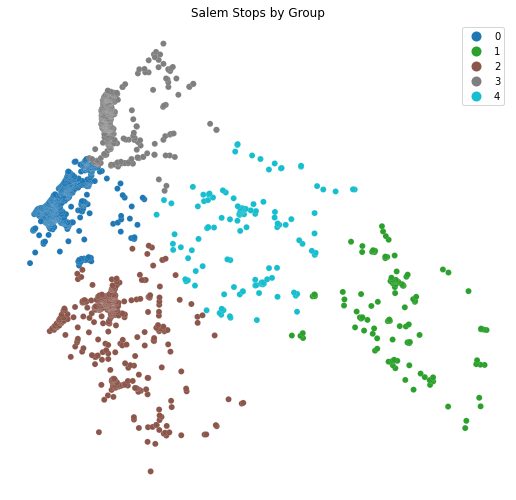

In [6]:
# if the gaol of scanning all target roadways in salem county is divided to 5 trips
from sklearn import cluster
from sklearn.preprocessing import scale

num_group = 5

training_data = np.concatenate((target_stops['geometry'].x.values.reshape(-1, 1), target_stops['geometry'].y.values.reshape(-1, 1)), axis=1)

km5 = cluster.KMeans(n_clusters=num_group)
km5cls = km5.fit(training_data)

target_stops['group'] = km5cls.labels_

f, ax = plt.subplots(1, figsize=(9, 9))
target_stops.assign(cl=km5cls.labels_).plot(column='cl', categorical=True, legend=True,linewidth=0.1, edgecolor='white', ax=ax)
ax.set_axis_off()
plt.title("Salem Stops by Group")
plt.show()

# Build Roadway Networks in a Focal Area

In [7]:
# get bounds of the focal group
transformer = Transformer.from_crs(3424, 4326, always_xy=True)

focal_group = 2

boundings_3424 = target_stops.loc[target_stops['group'] == focal_group, 'geometry'].total_bounds
boundings_4326_min = transformer.transform(boundings_3424[0], boundings_3424[1])
boundings_4326_max = transformer.transform(boundings_3424[2], boundings_3424[3])
boundings_4326 = np.concatenate([np.array(boundings_4326_min), np.array(boundings_4326_max)])
boundings_4326

array([-75.52629579,  39.43275701, -75.32638977,  39.61709439])

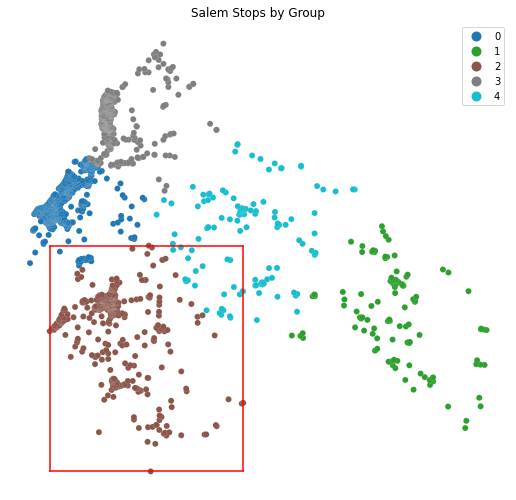

In [8]:
bbox = ((boundings_3424[0], boundings_3424[1]),
        (boundings_3424[0], boundings_3424[3]),
        (boundings_3424[2], boundings_3424[3]),
        (boundings_3424[2], boundings_3424[1]),
        (boundings_3424[0], boundings_3424[1]))

# city = ox.geocode_to_gdf('Salem County, NJ, USA')
# ax = ox.project_gdf(city).plot()
# _ = ax.axis('off')

f, ax = plt.subplots(1, figsize=(9, 9))
for i in range(len(bbox)-1):
    plt.plot((bbox[i][0], bbox[i+1][0]), (bbox[i][1], bbox[i+1][1]), color='red')
target_stops.assign(cl=km5cls.labels_).plot(column='cl', categorical=True, legend=True,linewidth=0.1, edgecolor='white', ax=ax)
ax.set_axis_off()
plt.title("Salem Stops by Group")
plt.show()

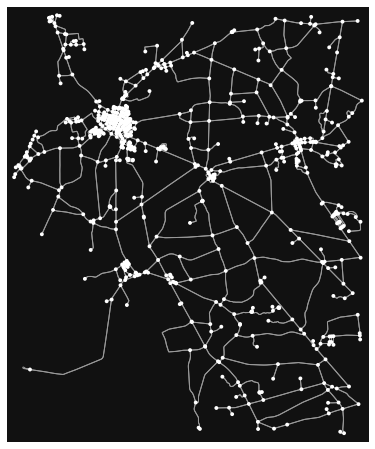

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [9]:
# retrieve roadway networks from osmnx database
G = ox.graph_from_bbox(boundings_4326[3], boundings_4326[1], boundings_4326[2], boundings_4326[0], network_type='drive') # ymax, ymin, xmax, xmin
nodes, edges = ox.graph_to_gdfs(G)
G_projected = ox.project_graph(G)
ox.plot_graph(G_projected)

In [10]:
nodes_reproj = nodes.copy()
nodes_reproj['geometry'] = nodes_reproj['geometry'].to_crs(epsg=3424)
nodes_reproj['x'] = np.array([[xy for xy in pts.coords] for pts in nodes_reproj['geometry'].values]).reshape(len(nodes_reproj), 2)[:, 0]
nodes_reproj['y'] = np.array([[xy for xy in pts.coords] for pts in nodes_reproj['geometry'].values]).reshape(len(nodes_reproj), 2)[:, 1]
nodes_reproj.head()

,y,x,street_count,highway,geometry
osmid,,,,,
103569164,235083.538346,254074.906713,3,NaN,POINT (254074.907 235083.538)
103569169,234170.017327,254071.437245,1,NaN,POINT (254071.437 234170.017)
103569182,235105.970069,254402.581693,3,NaN,POINT (254402.582 235105.970)
103569186,233719.264496,254400.911944,1,NaN,POINT (254400.912 233719.264)
103569227,235062.680524,253774.064088,3,NaN,POINT (253774.064 235062.681)


# Representing Target Stops Using Nearest Node on the Graph

In [33]:
x = np.array(target_stops_reproj.loc[0, 'geometry'].coords).flatten()[0]
y = np.array(target_stops_reproj.loc[0, 'geometry'].coords).flatten()[1]

node_id = ox.get_nearest_node(G, (y, x))

105211780

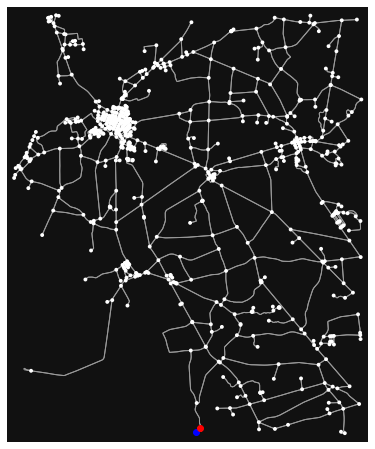

In [34]:
fig, ax = ox.plot_graph(G, show=False, close=False)
ax.scatter(x, y, c='blue')
ax.scatter(nodes.loc[node_id, 'x'], nodes.loc[node_id, 'y'], c='red')

In [43]:
len([ox.get_nearest_node(G,(np.array(stop).flatten()[1], np.array(stop).flatten()[0])) for stop in target_stops_reproj['geometry']])

2251

In [47]:
target_nodes = set([ox.get_nearest_node(G,(np.array(stop).flatten()[1], np.array(stop).flatten()[0])) for stop in target_stops_reproj['geometry']])
len(target_nodes)

340

# Solving Network-based TSP Using Christofides Algorithm

### complete graph & minimum spanning tree

In [57]:
G_TSP = nx.Graph()
G_TSP.add_nodes_from(target_nodes)

kn = nx.complete_graph(G_TSP)

for edge in kn.edges:
#     weight_set.add((edge[0], edge[1], nx.dijkstra_path_length(T, edge[0], edge[1], weight='length')))
    kn[edge[0]][edge[1]]['length'] = nx.dijkstra_path_length(G, edge[0], edge[1], weight='length')

min_spanning_tree = nx.minimum_spanning_tree(kn, weight='length')

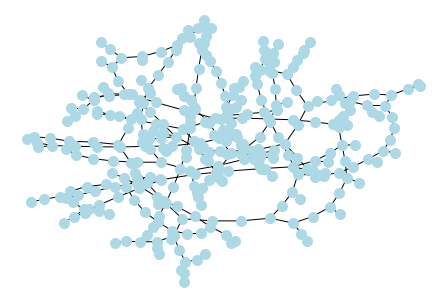

In [60]:
nx.draw(min_spanning_tree, node_color='lightblue', 
        with_labels=False, 
        node_size=100)

In [66]:
odd_degree_nodes = [node for (node, degree) in min_spanning_tree.degree if degree % 2 == 1]
nodes_to_remove = list(set(kn.nodes)-set(odd_degree_nodes))

kn_negative = kn.copy()
kn_negative.remove_nodes_from(nodes_to_remove)

for edge in kn_negative.edges:
    kn_negative[edge[0]][edge[1]]['length'] *= -1
    
min_cost_perfect_matching = nx.algorithms.matching.max_weight_matching(kn_negative, maxcardinality=True, weight='length')
print("minimum cost perfect matching complete!")

minimum cost perfect matching complete!


In [67]:
min_spanning_tree_2 = min_spanning_tree.copy()
for edge in min_cost_perfect_matching:
    if not min_spanning_tree.has_edge(edge[0], edge[1]):
        min_spanning_tree.add_edge(edge[0], edge[1], length = kn[edge[0]][edge[1]]['length'])
        min_spanning_tree_2.add_edge(edge[0], edge[1], length = kn[edge[0]][edge[1]]['length'])
    else:
        min_spanning_tree_2.remove_edge(edge[0], edge[1])
        
min_spanning_tree_recon = set(min_spanning_tree.to_directed().edges) - set(min_spanning_tree_2.edges)

In [74]:
def DFS(start_node, df):
    forward_visitation = []
    next_node = np.nan
    current_node = start_node
    forward_visitation.append(start_node)
    while next_node != start_node:
        
        candidate_edges = df[((df[-1] == current_node) | (df[1] == current_node)) & (df['visited'] == False)].index
        selected_edge = np.random.choice(candidate_edges)
        df.loc[selected_edge, 'visited'] = True

        if df.loc[selected_edge, -1] == current_node:
            next_node = df.loc[selected_edge, 1]
        else:
            next_node = df.loc[selected_edge, -1]

        current_node = next_node
        
        forward_visitation.append(current_node)
        
    return(forward_visitation)

edge_df = pd.DataFrame(min_spanning_tree_recon, columns=[-1, 1])
edge_df.insert(2, 'visited', False)

subloops = []

while False in edge_df['visited'].values:
    subloops.append(DFS(np.random.choice(edge_df.loc[edge_df['visited']== False, -1].values), edge_df))

if len(subloops) > 1:
    base_loop = np.array(subloops[0])
    for i in range(1, len(subloops)):
        temp_loop = np.array(subloops[i])
        common_node = set(base_loop).intersection(set(temp_loop))
        if len(common_node) > 0:
            pos_baseloop = np.where(np.array(base_loop) == list(common_node)[0])[0]
            pos_temploop = np.where(np.array(temp_loop) == list(common_node)[0])[0]
            # modify nodes position of temp loop
            temp_loop_mod = np.concatenate((temp_loop[pos_temploop[0]:], temp_loop[1:pos_temploop[0]]))
            # connect subloop
            base_loop = np.insert(base_loop, pos_baseloop[0], temp_loop_mod)

base_loop

array([ 105225922,  105224970,  105225874,  105228354,  105229180,
        105228413,  105228444,  105228450,  105228444,  105243151,
        105243156,  105243151,  105260072,  105255965,  105233204,
        105233199, 3245631666,  105233194,  105272228,  105267564,
        105233194,  105234372,  105268499,  105234372,  105224805,
        105224802,  105224805,  105224810,  105223667,  105223664,
        105223667,  105223670,  105223673,  105223675,  105266442,
        105260381,  105260376,  105260374,  105218052,  105218062,
        105218077,  105223715,  105218077,  105232763,  105226180,
        105232651,  105265592,  105202466, 8073848000,  105233430,
        105202466,  105206514,  105265592,  105214067,  105275560,
        105229564,  105209259,  105211688,  105265237,  105231096,
        105242899,  105203849,  105257358,  105209259,  105263653,
        105248987,  105229734,  105249019,  105263653,  105237056,
        105237358,  105214079,  105224682,  105219851,  105219

In [76]:
len(set(base_loop))

329

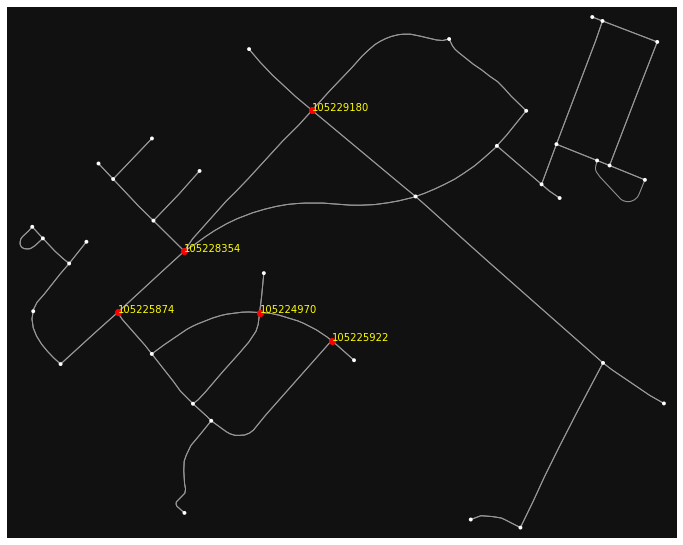

In [100]:
TSP_df = nodes.loc[base_loop[:5], :]

# fig, ax = ox.plot_graph(G, show=False, close=False)
TSP_G = ox.graph_from_point((TSP_df.iloc[0, 0], TSP_df.iloc[0, 1]), dist=500)

fig, ax = ox.plot_graph(TSP_G, figsize=(12,12), show=False, close=False)
ax.scatter(TSP_df['x'].values, TSP_df['y'].values, c='red')

for ix in TSP_df.index:
    ax.annotate(ix, (TSP_df.loc[ix, 'x'], TSP_df.loc[ix, 'y']), color='yellow')